#Parte 2 – Montar e avaliar uma rede neuronal para classificação binária

Para esta parte do trabalho, utilizou-se novamente o FASHION_MNIST com o objetivo de realizar uma classificação binária, dividindo as amostras em duas classes: Vestuário, e Calçado/Malas.

O código utilizado nas etapas iniciais é semelhante ao do notebook da Parte 1, uma vez que foi necessário redefinir as variáveis e conjuntos de dados iniciais para a nova abordagem.

#Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import keras
from keras import layers

#Dados e constantes

In [ ]:
# Inicializar os conjuntos de treino e teste, e a seed para garantir certa reprodutibilidade dos resultados
dataset = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = dataset.load_data()

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# constantes - dimensão das imagens
IMG_HEIGHT = 28
IMG_WIDTH = 28

# constantes - labels/classes e número de classes
LABELS = ["T-Shirt/Top",
          "Trouser",
          "Pullover",
          "Dress",
          "Coat",
          "Sandal",
          "Shirt",
          "Sneaker",
          "Bag",
          "Boot"]
N_CLASSES = 10

# callbacks
BEST_MODEL_CHECKPOINT = keras.callbacks.ModelCheckpoint(
    filepath="tmp/best_model.weights.h5",      # ficheiro para os pesos do "melhor modelo"
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

EARLY_STOPPING = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)

#Normalização

In [ ]:
# normalização
x_train = x_train / 255.0
x_test = x_test / 255.0

print("Número de amostras no training set original: " + str(x_train.shape[0]))
print("Número de amostras no test set original: " + str(x_test.shape[0]))
print("Não esquecer que se pretende também gerar um validation set!")

# transformar vetor das labels numa matriz - adequado para a classificação
# multiclasse da Parte 1, mas não para a classificação binária da Parte 2
y_train = keras.utils.to_categorical(y_train,N_CLASSES)
y_test = keras.utils.to_categorical(y_test,N_CLASSES)

Número de amostras no training set original: 60000
Número de amostras no test set original: 10000
Não esquecer que se pretende também gerar um validation set!


In [ ]:
# dimensões dos conjuntos de treino e teste
print("Dimensões do conjunto de treino (inputs):", x_train.shape, x_test.shape)
print("Dimensões do conjunto de teste (outputs):", y_train.shape, y_test.shape)

Dimensões do conjunto de treino (inputs): (60000, 28, 28) (10000, 28, 28)
Dimensões do conjunto de teste (outputs): (60000, 10) (10000, 10)


#Visualização

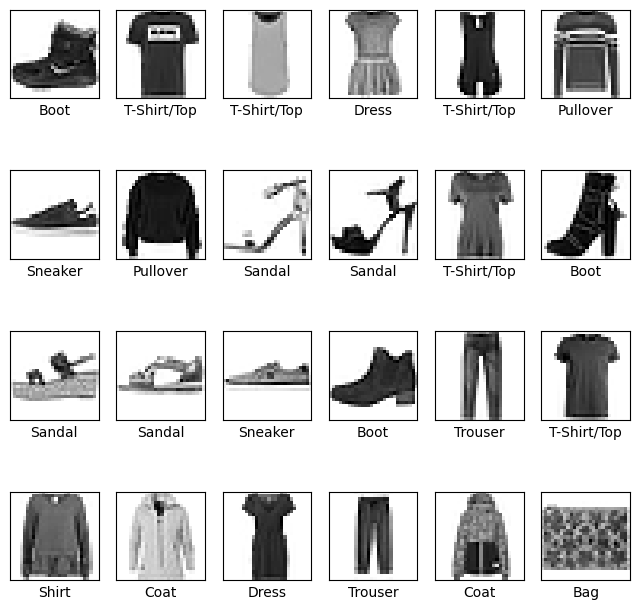

In [ ]:
plt.figure(figsize = (8, 8))

for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
    plt.xlabel(LABELS[np.argmax(y_train[i])])

plt.show()

###a) Realize as adaptações necessárias ao dataset original de modo a ter as novas labels: 1 será a classe Vestuário, e 0 será a classe Calçado e Malas (ou vice-versa)

Conjunto de validação para monitorizar o treino da rede. Foi implementado um passo adicional que converte as *labels* de uma codificação *one-hot* para inteiros, o que é necessário para a posterior classificação binária.

In [ ]:
from sklearn.model_selection import train_test_split

x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# Converção das labels para formato inteiro (de uma-hot para classe)
y_train2_int = np.argmax(y_train2, axis=1)
y_val_int = np.argmax(y_val, axis=1)
y_test_int = np.argmax(y_test, axis=1)

print("Novo conjunto de treino:", x_train2.shape[0])
print("Conjunto de validação:", x_val.shape[0])
print("Conjunto de teste:", x_test.shape[0])

Novo conjunto de treino: 48000
Conjunto de validação: 12000
Conjunto de teste: 10000


Criação de *labels* binários para classificação entre Vestuário e Calçado/Malas

In [ ]:
# Classificação de T-Shirt/Top, Trouser, Pullover, Dress, Coat e Shirt como roupa
# O vestuário é classificado como 1 e calçado e malas como 0.
roupas = [0, 1, 2, 3, 4, 6]
y_train2_binary = np.where(np.isin(y_train2_int, roupas), 1, 0)
y_val_binary = np.where(np.isin(y_val_int, roupas), 1, 0)
y_test_binary  = np.where(np.isin(y_test_int, roupas), 1, 0)

print("Treino novo:", y_train2_binary.shape)
print("Validação:", y_val_binary.shape)
print("Teste:", y_test_binary.shape)

Treino novo: (48000,)
Validação: (12000,)
Teste: (10000,)


###b) Adapte os passos b) a g) da Parte 1, aplicados agora a esta nova rede


Modelo de rede neuronal para classificação binária.

Para a classificação binária, usamos a estrutura do modelo apresentado na Parte 1, tendo alterado a função de ativação da camada de saída para *sigmoid*, pois é ideal para problemas de classificação binária. O otimizador utilizado foi o *Adam*, que oferece uma atualização eficiente dos pesos, e a função de perda escolhida foi a *binary_crossentropy*, adequada para problemas binários. Assim como na Parte 1, o modelo foi treinado por 50 *epochs*, utilizando os *callbacks* para salvar o melhor modelo e interromper o treino caso não haja melhoria na validação após 5 *epochs* consecutivos.

In [ ]:
modelo_2 = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape = (28, 28)),

    tf.keras.layers.Dense(128, activation = 'relu'),

    tf.keras.layers.Dense(64, activation = 'relu'),

    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

modelo_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005), loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacksprof = [BEST_MODEL_CHECKPOINT, EARLY_STOPPING]

fit_modelo2_treino = modelo_2.fit(x_train2, y_train2_binary, epochs = 50, batch_size = 64,  validation_data=(x_val, y_val_binary), callbacks = callbacksprof, verbose = 1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9749 - loss: 0.0772 - val_accuracy: 0.9904 - val_loss: 0.0347
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9920 - loss: 0.0288 - val_accuracy: 0.9932 - val_loss: 0.0252
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9940 - loss: 0.0203 - val_accuracy: 0.9937 - val_loss: 0.0216
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9955 - loss: 0.0149 - val_accuracy: 0.9936 - val_loss: 0.0230
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9963 - loss: 0.0115 - val_accuracy: 0.9933 - val_loss: 0.0246
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9969 - loss: 0.0093 - val_accuracy: 0.9937 - val_loss: 0.0241
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9979 - loss: 0.0069 - val_accuracy: 0.9940 - val_loss: 0.0251
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9981 - loss: 0.0060 - val_accuracy: 0

In [ ]:
# Sumário do modelo treinado
modelo_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 326,405 (1.25 MB)

 Trainable params: 108,801 (425.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 217,604 (850.02 KB)

O sumário do modelo descreve a arquitetura da rede neuronal sequencial:
1. Camada de Entrada: transforma as imagens bidimensionais (28x28) num vetor unidimensional com 784 elementos (28 * 28 = 784). Não possui parâmetros treináveis, pois apenas reorganiza os dados.
2. Camada Oculta 1: conectada com 128 neurónios que resultam em 100.480 parâmetros (128 * 784 = 100.480).
3. Camada Oculta 2: conectada com 64 neurónios que resultam em 8.256 parâmetros (128 * 64 = 8.256).
5. Camada de Saída: apresenta 1 neurónio correspondente à classe binária 1 do dataset e 65 parâmetros (64 * 1 + 1 = 65).

Gráficos para a representação da evolução da perda e dos acertos durante o treino: o gráfico *Training and Validation Accuracy* e gráfico *Training and Validation Loss*. Estes gráficos são essenciais para avaliar se o modelo está a aprender com os dados de treino e como está a generalizar para os dados de validação.

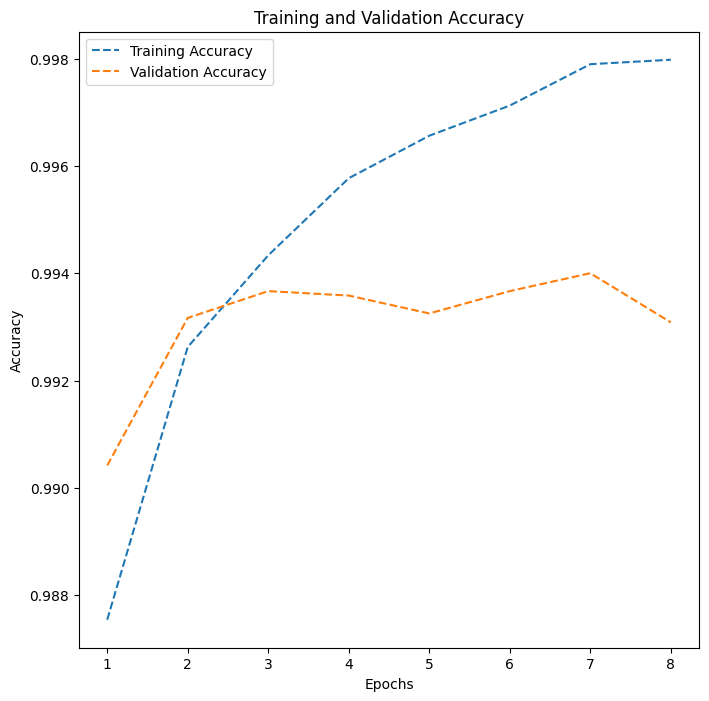

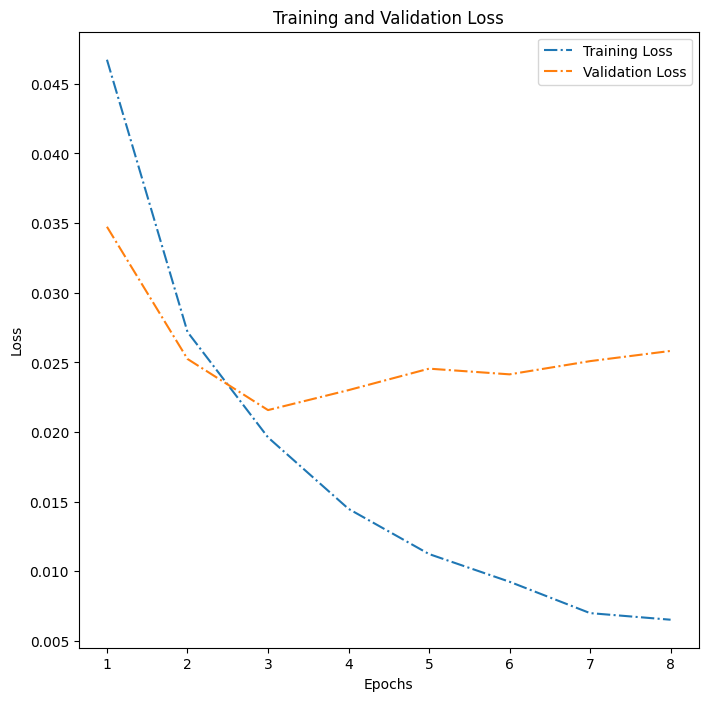

In [ ]:
dict_hist2 = fit_modelo2_treino.history

epochs = [i for i in range(1, len(dict_hist2['accuracy']) + 1)]

plt.figure(figsize=(8, 8))
plt.plot(epochs, dict_hist2['accuracy'], ls='--', label='Training Accuracy')
plt.plot(epochs, dict_hist2['val_accuracy'], ls='--', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(epochs, dict_hist2['loss'], ls='-.', label='Training Loss')
plt.plot(epochs, dict_hist2['val_loss'], ls='-.', label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Gráfico *Training and Validation Accuracy***

*   A precisão no conjunto de treino apresenta uma tendência ascendente consistente, indicando que o modelo está a aprender os padrões dos dados de treino. No final, a precisão atinge perto de 99,8%, o que sugere um bom ajuste aos dados de treino.
*   A precisão na validação também apresenta uma tendência crescente nos primeiros *epochs*, mas estabiliza por volta do *epoch* 7 em torno de 99,4%. Isto indica que o modelo atingiu um ponto ótimo de generalização para os dados de validação.


**Gráfico *Training and Validation Loss***

*   A perda no treino diminui consistentemente ao longo dos *epochs*, enquanto a perda na validação diminui nas primeiros *epochs* e atinge o mínimo por volta do *epoch* 3, com valores ligeiramente superiores aos do treino.

In [ ]:
pred_probs = modelo_2.predict(x_test)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4000
           1       1.00      0.99      0.99      6000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



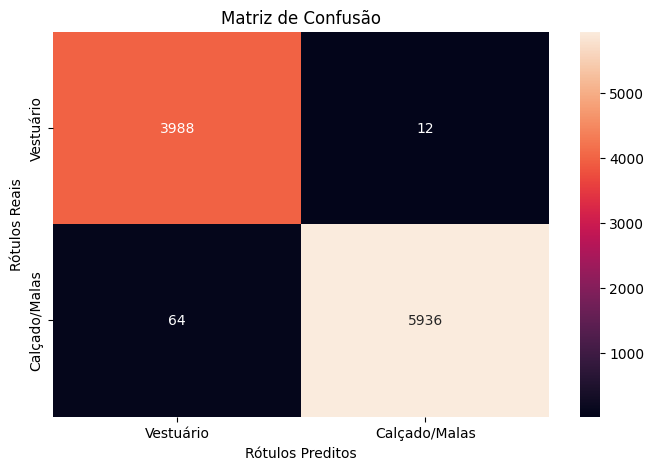

In [ ]:
# Função para calcular e apresentar métricas de avaliação do modelo
def metrics_score2(actual, predicted):

    labels_novos = ["Vestuário", "Calçado/Malas"]

    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = labels_novos, yticklabels = labels_novos)

    plt.title('Matriz de Confusão')

    plt.ylabel('Rótulos Reais')

    plt.xlabel('Rótulos Preditos')

    plt.show()

# Previsões para o conjunto de teste
metrics_score2(y_test_binary, pred_labels)

**Classe 0 (Calçado e Malas):**

*   A precisão é de 98%, o que significa que das predições que o modelo fez como sendo da classe 0, 98% estavam corretas.
*   O *recall* é de 100%, indicando que o modelo conseguiu identificar corretamente todos os exemplos reais desta classe.

**Classe 1 (Vestuário):**

*   A precisão é de 100%, ou seja, todas as predições feitas como sendo da classe 1 estavam corretas.
*   O *recall* é de 99%, o que significa que o modelo deixou de identificar apenas uma pequena fração dos exemplos reais desta classe.

Não há evidências significativas de confusões entre as classes, indicando que o modelo é altamente eficaz para esta tarefa binária.

De modo a fazer uma verificação adicional para descartar a presença de *overfitting*, procedemos também à análise das métricas e da matriz de confusão para os conjuntos de treino e validação:

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19230
           1       1.00      1.00      1.00     28770

    accuracy                           1.00     48000
   macro avg       1.00      1.00      1.00     48000
weighted avg       1.00      1.00      1.00     48000



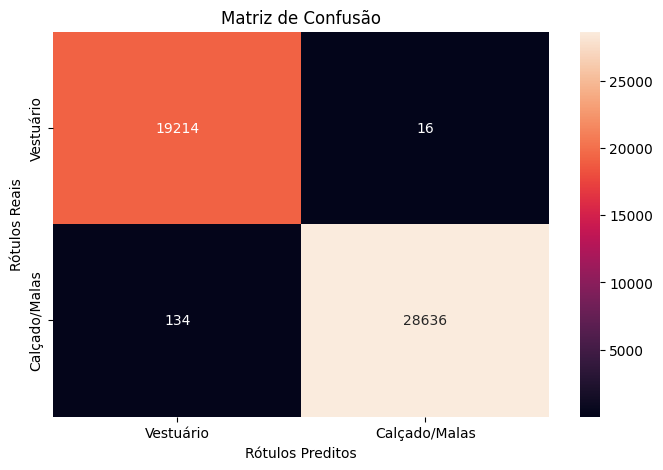

In [ ]:
# Previsões para o conjunto de treino
train_preds_probs = modelo_2.predict(x_train2)
train_preds_labels = (train_preds_probs > 0.5).astype(int).flatten()
metrics_score2(y_train2_binary, train_preds_labels)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4770
           1       1.00      0.99      0.99      7230

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



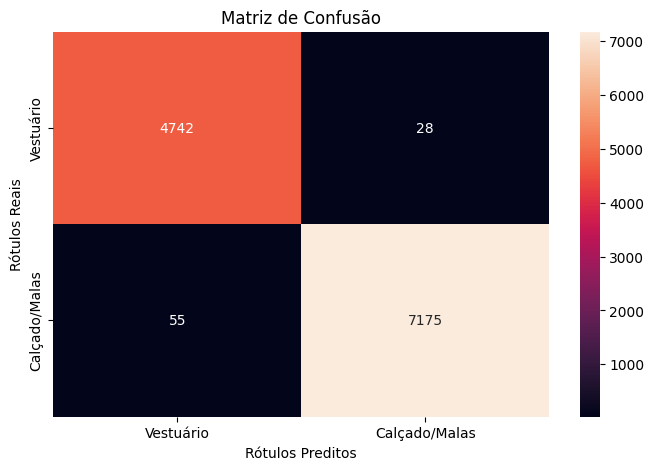

In [ ]:
# Previsões para o conjunto de validação
val_preds_probs = modelo_2.predict(x_val)
val_preds_labels = (val_preds_probs > 0.5).astype(int).flatten()
metrics_score2(y_val_binary, val_preds_labels)

Dado que os valores das métricas são semelhantes, podemos concluir que não há indícios de *overfitting*.